## [pyKNEEr](https://github.com/sbonaretti/pyKNEEr)

# [Preprocessing MR Knee Images](https://sbonaretti.github.io/pyKNEEr/preprocessing.html)
Content under Creative Commons Attribution license CC-BY-NC-SA 4.0   
Code under GNU-GPL v3 License  
© 2019 Serena Bonaretti
---

Preprocessing of MR images is fundamental to standardize spatial information and intensity of images

In the pipeline below:
- Steps 1-3 uniform image orientation, knee laterality, and image origin. The resulting image has the same intensity as the acquired `.dcm` image, but different collocation in space. It is saved as `_orig.mha`
- Steps 4-6 act on the intensities of the image, by correcting the inhomogeneous magnetic field, rescaling to a fixed range, and enhancing the cartilage contours [1]. The resulting image has different intensity than the acquired `.dcm` image, and it is used for atlas-based segmentation. It is saved as `_prep.mha`. These steps are computationally expensive, so if not needed, avoid them by setting `intensity_standardization` to zero (see below) 

## Import packages

In [12]:
import sys
import importlib
sys.path.append(r'../../pykneer')
sys.path.append(r'../pykneer')
import pykneer_io as io
importlib.reload(io)
import preprocessing_for_nb as prep
importlib.reload(prep)

import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

In [13]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images0(image_z, image):
    img = image[image_z,:,:]
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_images2(image_z, image):
    img = image[:,:,image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

## Image information

Inputs:   
- `input_file_name` contains the list of the images to be preprocessed 
- `nOfCores` is the number of cores used for computations (computations are parallelized for speed)
- `intensity_standardization` is a flag that determines if the intensity standardization is performed (0=no, 1=yes)

In [3]:
input_file_name           = ".\image_list_preprocessing.txt"
n_of_cores                = 1 # change the number of cores according to your computer
intensity_standardization = 1

#### Read image data
- `imageData` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [28]:
image_data = io.load_image_data_preprocessing(input_file_name)

9189303L_TP0
9189303L_TP1
-> information loaded for 2 subjects


In [29]:
ref = sitk.ReadImage('../../reference/newsubject/reference.mha')
interact(display_images0, 
         image_z=(0,ref.GetSize()[0]-1), 
         image=fixed(ref));

interactive(children=(IntSlider(value=79, description='image_z', max=159), Output()), _dom_classes=('widget-in…

In [30]:
ref.GetSize()

(160, 384, 384)

In [31]:
ref.GetSpacing()

(0.7, 0.364583, 0.364583)

In [32]:
ref.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [33]:
image_data[1]

{'original_folder': '..\\..\\original\\',
 'preprocessed_folder': '..\\..\\preprocessed\\',
 'image_folder_file_name': '9189303L\\TP1',
 'laterality': 'left',
 'image_name_root': '9189303L_TP1',
 'temp_file_name': '..\\..\\preprocessed\\9189303L_TP1_temp.mha',
 'original_file_name': '..\\..\\preprocessed\\9189303L_TP1_orig.mha',
 'preprocessed_file_name': '..\\..\\preprocessed\\9189303L_TP1_prep.mha',
 'info_file_name': '..\\..\\preprocessed\\9189303L_TP1_orig.txt'}

## Spatial standardization

#### Step 0: Read the dicom images

In [34]:
prep.read_dicom_stack(image_data, n_of_cores)

-> Dicom images read
-> The total time was 3.33 seconds (about 0 min)


In [35]:
tmp_file_name = image_data[0]["temp_file_name"]
# read the images
img_tmp = sitk.ReadImage(tmp_file_name)
interact(display_images0,
         image_z=(0,img_tmp.GetSize()[0]-1),
         image=fixed(img_tmp));

interactive(children=(IntSlider(value=191, description='image_z', max=383), Output()), _dom_classes=('widget-i…

In [36]:
interact(display_images2,
         image_z=(0,img_tmp.GetSize()[2]-1),
         image=fixed(img_tmp));

interactive(children=(IntSlider(value=37, description='image_z', max=74), Output()), _dom_classes=('widget-int…

In [37]:
img_tmp.GetSize()

(384, 384, 75)

In [38]:
img_tmp.GetSpacing()

(0.36458333, 0.36458333, 1.5)

#####   Save image header
The image header of the first slice of the dicom stack is saved in a `.txt` file. This can be useful to extract information such as subject's date of birth, exam date, etc.

In [39]:
prep.print_dicom_header(image_data, n_of_cores)

-> Dicom headers written
-> The total time was 1.45 seconds (about 0 min)


#### Step 1: Change orientation to RAI 
All images are oriented to the RAI (right, anterior, inferior) orientation

In [40]:
#prep.axial_to_sagittal(image_data, n_of_cores)
prep.orientation_to_rai(image_data, n_of_cores)

-> Image orientation changed
-> The total time was 3.19 seconds (about 0 min)


In [41]:
tmp_file_name = image_data[0]["temp_file_name"]
# read the images
img_tmp = sitk.ReadImage(tmp_file_name)
interact(display_images2, 
         image_z=(0,img_tmp.GetSize()[2]-1), 
         image=fixed(img_tmp));

interactive(children=(IntSlider(value=37, description='image_z', max=74), Output()), _dom_classes=('widget-int…

#### Step 2: Change laterality if knee is right
Right knees are flipped to left knees to have the same laterality 

In [42]:
prep.flip_rl(image_data, n_of_cores)

-> Image laterality changed for right images
-> The total time was 1.13 seconds (about 0 min)


In [43]:
tmp_file_name = image_data[0]["temp_file_name"]
# read the images
img_tmp = sitk.ReadImage(tmp_file_name)
interact(display_images2, 
         image_z=(0,img_tmp.GetSize()[2]-1), 
         image=fixed(img_tmp))

interactive(children=(IntSlider(value=37, description='image_z', max=74), Output()), _dom_classes=('widget-int…

<function __main__.display_images2(image_z, image)>

#### 3. Set image origin to (0,0,0)
All images are set to the origin (0,0,0). Images are saved as *_orig.mha and they are anonymized

In [44]:
prep.origin_to_zero(image_data, n_of_cores)

-> Image origin changed
-> _orig.mha images saved
-> The total time was 1.61 seconds (about 0 min)


## Intensity standardization

#### 4. Correct magnetic field inhomogeneities
Magnetic fields inhomogeneities create grey shades on images. This correction removes these shades. This is the longest step of the processing. It can take up to 15-20 min on a standard PC or laptop

In [45]:
if intensity_standardization == 1:
    prep.field_correction(image_data, n_of_cores) 

-> Magnetic field bias corrected
-> The total time was 186.98 seconds (about 3 min)


In [46]:
tmp_file_name = image_data[0]["temp_file_name"]
# read the images
img_tmp = sitk.ReadImage(tmp_file_name)
interact(display_images2, 
         image_z=(0,img_tmp.GetSize()[2]-1), 
         image=fixed(img_tmp));

interactive(children=(IntSlider(value=37, description='image_z', max=74), Output()), _dom_classes=('widget-int…

#### 5. Rescale intensities to [0 100]
Intensies are rescaled to the fixed range [0,100] to obtain homogeneous intensity range across images

In [47]:
if intensity_standardization == 1:
    prep.rescale_to_range(image_data, n_of_cores) 

-> Image intensities rescaled
-> The total time was 1.74 seconds (about 0 min)


#### 6. Edge preserving smoothing
Cartilage contours are enhanced using a curvature anisotropic diffusion filter

In [48]:
if intensity_standardization == 1:
    prep.edge_preserving_smoothing(image_data, n_of_cores) 

-> Image smoothed
-> _prep.mha images saved
-> The total time was 16.51 seconds (about 0 min)


## Visualize original and preprocessed image
Set the variable `view_modality` to `0` to show one slice of the image (static and faster rendering) or to `1` to scroll though the image (interactive and slower rendering). Note that when using interactive rendering, images might NOT be saved  for when reopening the notebook.

Each row corresponds to one image. Left: Original image after spatial preprocessing (steps 1-3). Right: Preprocessed image after intensities correction (steps 4-6).  
*Note*: A total black rendering of an original image is caused by very large intensity distribution.

'Figure'

<Figure size 576x576 with 0 Axes>

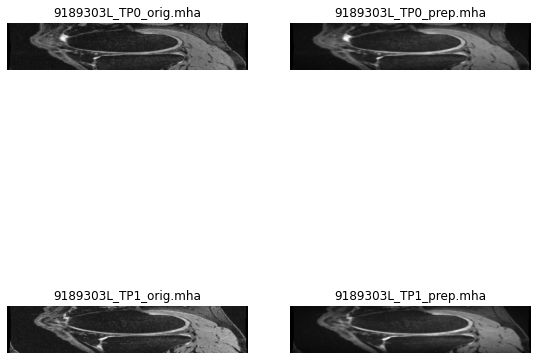

In [49]:
view_modality = 0; # 0 for static, 1 for interactive
fig = prep.show_preprocessed_images(image_data, intensity_standardization, view_modality);
display(fig)

---

### References

[1] Shan L., Zach C., Charles C., Niethammer M. [*Automatic Atlas-Based Three-Label Cartilage Segmentation from MR Knee Images.*](https://www.ncbi.nlm.nih.gov/pubmed/25128683) Med Image Anal. Oct;18(7):1233-46. 2014.

### Dependencies

In [32]:
%load_ext watermark
%watermark -v -m -p pykneer,SimpleITK,itk,numpy,matplotlib,multiprocessing,ipywidgets,watermark
print (" ")
%watermark -u -n -t -z 

CPython 3.7.4
IPython 7.8.0

pykneer 0.0.5
SimpleITK 1.2.0rc2.dev1167+gd4cf2
itk 5.1.1
numpy 1.19.1
matplotlib 3.1.1
multiprocessing unknown
ipywidgets 7.5.1
watermark 2.0.2

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 79 Stepping 1, GenuineIntel
CPU cores  : 12
interpreter: 64bit
 
last updated: Thu Sep 17 2020 19:15:22 Pacific Daylight Time


In [26]:
ref = sitk.ReadImage('D:/Yin/OAI/pyKNEEr-yg/reference/newsubject/reference_f.mha')
interact(display_images0, 
         image_z=(0,ref.GetSize()[0]-1), 
         image=fixed(ref));

interactive(children=(IntSlider(value=79, description='image_z', max=159), Output()), _dom_classes=('widget-in…

(array([128113.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  19343.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

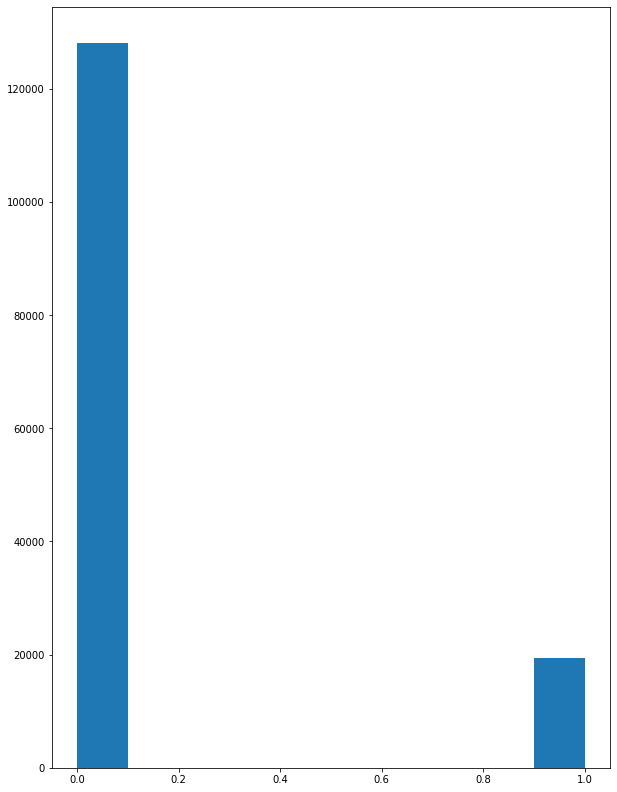

In [27]:
plt.hist(ref[86,:,:,])